## Applying clustering algorithms


### Hierarchical clustering applied to image processing


This first example applies hierarchical clustering to a 2D image and attempts to produce a spacially constrained image segmentation.

Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_lena_ward_segmentation.html


In [1]:
import time as time
import numpy as np
import scipy as sp
import pylab as pl
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import Ward
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

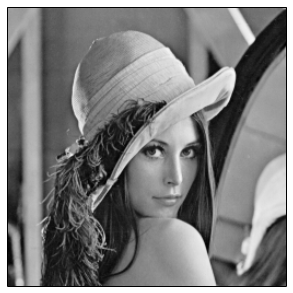

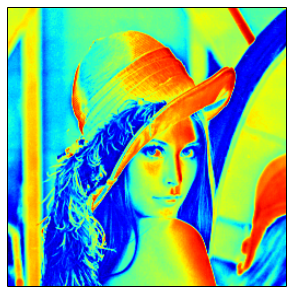

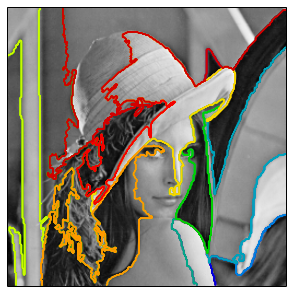

In [2]:
###############################################################################
# Generate data
lena = sp.misc.lena()
# Downsample the image by a factor of 4
lena = lena[::2, ::2] + lena[1::2, ::2] + lena[::2, 1::2] + lena[1::2, 1::2]
X = np.reshape(lena, (-1, 1))

###############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*lena.shape)

###############################################################################
# Compute clustering
st = time.time()
n_clusters = 15  # number of regions
ward = Ward(n_clusters=n_clusters, connectivity=connectivity).fit(X)
label = np.reshape(ward.labels_, lena.shape)

###############################################################################
# Plot the results on an image
pl.figure(1,figsize=(5, 5))
pl.imshow(lena,cmap=pl.cm.gray); pl.xticks(()); pl.yticks(())

pl.figure(2,figsize=(5, 5))
pl.imshow(lena); pl.xticks(()); pl.yticks(())
pl.figure(3,figsize=(5, 5))
pl.imshow(lena, cmap=pl.cm.gray)

for l in range(n_clusters):
    pl.contour(label == l, contours=1,
               colors=[pl.cm.spectral(l / float(n_clusters)), ])
pl.xticks(())
pl.yticks(())
pl.show()

### Reducing the number of colors with K-means clustering


This examlpe performs a pixel-wise Vector Quantization (VQ) of an image of the summer palace (China), reducing the number of colors required to show the image from 96,615 unique colors to 64, while preserving the overall appearance quality.

In this example, pixels are represented in a 3D-space and K-means is used to find 64 color clusters. In the image processing literature, the codebook obtained from K-means (the cluster centers) is called the color palette. Using a single byte, up to 256 colors can be addressed, whereas an RGB encoding requires 3 bytes per pixel. The GIF file format, for example, uses such a palette.

For comparison, a quantized image using a random codebook (colors picked up randomly) is also shown.

Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html


Fitting model on a small sub-sample of the data
done in 3.160s.
Predicting color indices on the full image (k-means)
done in 0.584s.
Predicting color indices on the full image (random)
done in 0.522s.


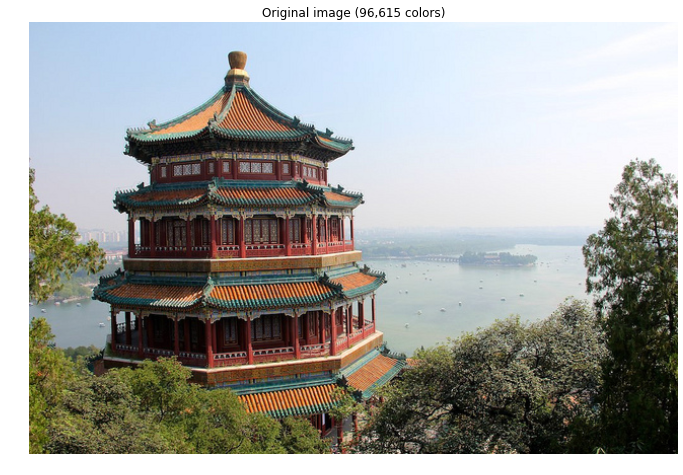

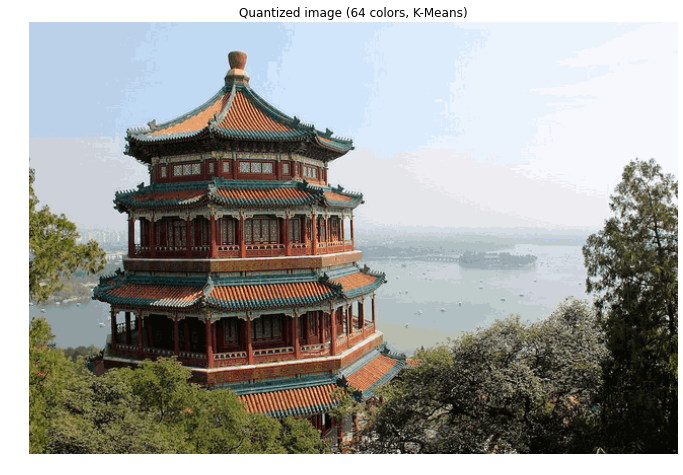

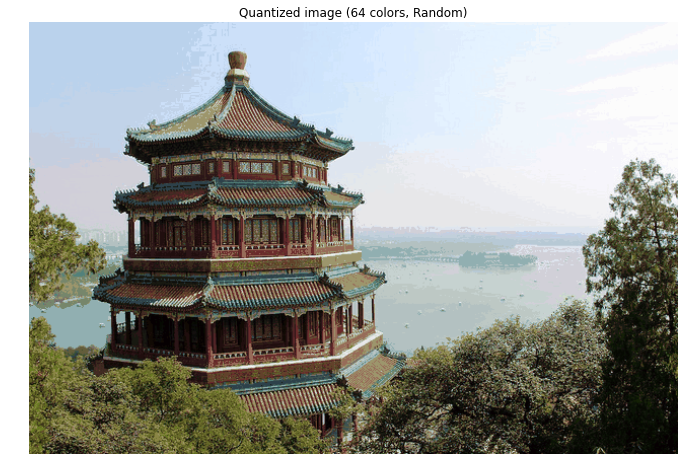

In [3]:
n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that pl.imshow behaves works well on float data (need to
# be in the range [0-1]
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time.time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time.time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time.time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time.time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors + 1]
print("Predicting color indices on the full image (random)")
t0 = time.time()
dist = euclidean_distances(codebook_random, image_array, squared=True)
labels_random = dist.argmin(axis=0)
print("done in %0.3fs." % (time.time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
pl.figure(1,figsize=(10, 6))
pl.clf()
ax = pl.axes([0, 0, 1, 1])
pl.axis('off')
pl.title('Original image (96,615 colors)')
pl.imshow(china)

pl.figure(2,figsize=(10, 6))
pl.clf()
ax = pl.axes([0, 0, 1, 1])
pl.axis('off')
pl.title('Quantized image (64 colors, K-Means)')
pl.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

pl.figure(3,figsize=(10, 6))
pl.clf()
ax = pl.axes([0, 0, 1, 1])
pl.axis('off')
pl.title('Quantized image (64 colors, Random)')
pl.imshow(recreate_image(codebook_random, labels_random, w, h))
pl.show()